In [2]:
import h5py
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'figure.figsize': (6,4)})
import pandas as pd
import seaborn as sns
from copy import deepcopy
import warnings

import sys
import os
import subprocess
import glob
from collections import defaultdict
import scipy as sp
from scipy import special
from itertools import product

from scipy.io import savemat

In [61]:
main_dir = "/home/igraham/data/MD_LV_paper_data"
hertz_pred = glob.glob(f"{main_dir}/hertz_pred_final/*")
lj_pred = glob.glob(f"{main_dir}/lj_pred_final/*")
lj_pred_25 = glob.glob(f"{main_dir}/lj_pred_lastone/*")
hertz_val = glob.glob(f"{main_dir}/hertz_val/*")
lj_val = glob.glob(f"{main_dir}/lj_val/*")
lj_val_25 = glob.glob(f"{main_dir}/lj_val_lastone/*")
hertz_val = glob.glob(f"{main_dir}/hertz_val/*")
hertz_temp = glob.glob(f"{main_dir}/hertz_therm/*")
lj_temp = glob.glob(f"{main_dir}/lj_therm/*")

In [50]:
lj_val_25[0]

'/home/igraham/data/MD_LV_paper_data/lj_val_lastone/genvariant_n-10_na-4_l-3.015113445777636_t-0.1_time-10_dt-1e-3_visc-5_seed-23001_phi-1.1000_pot-lj_rs-1_vs-0.1.h5'

In [51]:
lj_pred_25[0]

'/home/igraham/data/MD_LV_paper_data/lj_pred_lastone/genvariant_n-10_na-4_l-3.015113445777636_t-0.1_time-10_dt-1e-3_visc-5_seed-13002_phi-1.1000_pot-lj_rs-1_vs-0.1.h5'

In [4]:
len(lj_pred_25), len(lj_val_25)

(100, 110)

In [163]:
hertz_pred_highdt = glob.glob(f"{main_dir}/hertz_pred_highdt/*")
lj_pred_highdt = glob.glob(f"{main_dir}/lj_pred_highdt/*")
len(hertz_pred_highdt), len(lj_pred_highdt)

(100, 100)

In [ ]:
hertz_pred_highdt = glob.glob(f"{main_dir}/hertz_pred_more/*")
lj_pred_highdt = glob.glob(f"{main_dir}/lj_pred_more/*")
len(hertz_pred_highdt), len(lj_pred_highdt)

In [7]:
figure_path = "/home/igraham/data/MD_LV_paper_figures/"

In [8]:
len(hertz_pred), len(lj_pred), len(hertz_val), len(lj_val), len(hertz_temp), len(lj_temp)

(100, 100, 1100, 1100, 1100, 1100)

In [6]:
def plot_msd(dic, ax=None, colorbar=False, log=True, max_t=None, mask_opacity=None, val=False):
    if ax is None:
        plt.figure()
    else:
        plt.sca(ax)
        
    if val:
        marker = "-"
    else:
        marker = "."
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dVs = np.abs(dic["dVs"]) + 1
        mdVs = sorted(dVs)
        norm = dic["Norm"]
        MSD = dic["MSD"]
        time = dic["time"]
        Ns = dic["real"]
        # dVs = np.linspace(2.0, 11.0, 10)
        lmax = None

        cmap = cm.viridis
        nor = colors.Normalize(vmin=mdVs[1], vmax=mdVs[-1])

        sm = cm.ScalarMappable(cmap=cmap, norm=nor)

        for i in np.arange(len(MSD)):
            if not val:
                N = Ns
                msd = MSD[i]
                n = norm[i]
            else:
                N = Ns[i]
                msd = MSD[i,0]
                n = norm[i,0]
                
            M = n/N
            msd = msd/n
            if max_t is not None:
                msd = np.where(time <= max_t, msd, np.nan)
            mask = np.where(np.abs(M-1) < 0.1, msd, np.nan)
#             nans = np.argwhere(np.isnan(mask))
            if dVs[i] == mdVs[0]:
                if val:
                    continue
                color = "k"
                plt.plot(time, mask, "--", color=color, label=r"$\tilde V$")
                lmax = np.max(np.nan_to_num(mask))*1.1
            else:
                color = cmap(nor(dVs[i]))
                plt.plot(time, mask, marker, color=color)
                if mask_opacity is not None:
                    mask = np.where(np.abs(M-1) < 0.1, np.nan, msd)
                    plt.plot(time, mask, "-", color=color, alpha=mask_opacity)
            
#         plt.legend()

        if colorbar:
            plt.colorbar(sm, label=r"$\chi$")
        plt.ylabel(r"$\langle \mathcal{MSD} \rangle$")
        plt.xlabel(r"$t$")
        if log:
            plt.yscale('log')
            plt.xscale('log')
        if lmax is not None:
            lims = plt.ylim()
            plt.ylim((lims[0], lmax))
        return sm

In [7]:
def plot_Ib(dic, ax=None, colorbar=False, max_t=None):
    if ax is None:
        plt.figure()
    else:
        plt.sca(ax)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dVs = np.abs(dic["dVs"]) + 1
        mdVs = sorted(dVs)
        norm = dic["Norm"]
        time = dic["time"]
        N = dic["real"]

        cmap = cm.viridis
        nor = colors.Normalize(vmin=mdVs[0], vmax=mdVs[-1])

        sm = cm.ScalarMappable(cmap=cmap, norm=nor)

        for i in range(1, len(norm)):
            M = norm[i]/N
            mask = np.abs(M-1)
            if max_t is not None:
                mask = np.where(time <= max_t, mask, np.nan)
            plt.plot(time, mask, color=cmap(nor(dVs[i])))
        if colorbar:
            plt.colorbar(sm, label=r"$\chi$")
        plt.ylabel(r"$\mid \mathcal{N} - 1 \mid$")
        plt.xlabel(r"$t$")
        plt.yscale('log')
        return sm

In [8]:
def plot_q0(dic, ax=None, colorbar=False, max_t=None, mask_opacity=None, val=False):
    if ax is None:
        plt.figure()
    else:
        plt.sca(ax)
        
    if val:
        marker = "-"
    else:
        marker = "."
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dVs = np.abs(dic["dVs"]) + 1
        mdVs = sorted(dVs)
        norm = dic["Norm"]
        Q = dic["Q"][:,0]
        time = dic["time"]
        Ns = dic["real"]
        # dVs = np.linspace(2.0, 11.0, 10)
        lmax = None

        cmap = cm.viridis
        nor = colors.Normalize(vmin=mdVs[1], vmax=mdVs[-1])

        sm = cm.ScalarMappable(cmap=cmap, norm=nor)

        for i in np.arange(len(Q)):
            if not val:
                N = Ns
                q = Q[i]
                n = norm[i]
            else:
                N = Ns[i]
                q = Q[i,0]
                n = norm[i,0]
            
            M = n/N
            q = q/n
            if max_t is not None:
                q = np.where(time <= max_t, q, np.nan)
            mask = np.where(np.abs(M-1) < 0.1, q, np.nan)
            
            nans = np.argwhere(np.isnan(mask))
            if dVs[i] == mdVs[0]:
                if val:
                    continue
                color = "k"
                plt.plot(time, mask, "--", color=color, label=r"$\tilde V$")
                lmax = np.max(np.nan_to_num(mask))*1.1
            else:
                color = cmap(nor(dVs[i]))
                plt.plot(time, mask, marker, color=color)
                if mask_opacity is not None:
                    mask = np.where(np.abs(M-1) < 0.1, np.nan, q)
                    plt.plot(time, mask, "-", color=color, alpha=mask_opacity)
                
#         plt.legend()
        if colorbar:
            plt.colorbar(sm, label=r"$\chi$")
        plt.ylabel(r"$Q(0.1)$")
        plt.xlabel(r"$t$")
        plt.xscale('log')
        if lmax is not None:
            lims = plt.ylim()
            plt.ylim((lims[0], lmax))
        return sm

In [9]:
def collect_h5_files_into_data(files, val=False, v0=1.0):
    data = {}
    if val:
        pre_data = {}
        for i, f in enumerate(sorted(files)):
            if i%(len(files)//10)==0:
                print(i, "of", len(files))
            with h5py.File(f, "r") as f:
                dv = 1.0 - f["meta"]["vscale"][()]/v0
                if dv in pre_data:
                    d = pre_data[dv]
                    d["Norm"] += f["data"]["Norm"][:]
                    d["MSD"] += f["data"]["MSD"][:]
                    d["Q"] += f["data"]["Q"][:]
                    d["real"] += f["real"][0]
                else:
                    pre_data[dv] = {}
                    d = pre_data[dv]
                    if i == 0:
                        data["time"] = f["data"]["time"][:]
                    d["Norm"] = f["data"]["Norm"][:]
                    d["MSD"] = f["data"]["MSD"][:]
                    d["Q"] = f["data"]["Q"][:]
                    d["real"] = f["real"][0]
                
        data["dVs"] = []
        data["Norm"] = []
        data["MSD"] = []
        data["Q"] = []
        data["real"] = []
        
        for k, d in pre_data.items():
            data["dVs"].append(k)
            data["Norm"].append(d["Norm"])
            data["MSD"].append(d["MSD"])
            data["Q"].append(d["Q"])
            data["real"].append(d["real"])
        
        data["dVs"] = np.array(data["dVs"])
        data["Norm"] = np.array(data["Norm"])
        data["MSD"] = np.array(data["MSD"])
        data["Q"] = np.array(data["Q"])
    else:
        for i, f in enumerate(sorted(files)):
            if i%(len(files)//10)==0:
                print(i, "of", len(files))
            with h5py.File(f, "r") as f:
                if i == 0:
                    data["dVs"] = f["param"]["dVs"][:]
                    data["time"] = f["data"]["time"][:]
                    data["Norm"] = f["data"]["Norm"][:]
                    data["MSD"] = f["data"]["MSD"][:]
                    data["Q"] = f["data"]["Q"][:]
                    data["real"] = f["real"][0]
                else:
                    data["Norm"] += f["data"]["Norm"][:]
                    data["MSD"] += f["data"]["MSD"][:]
                    data["Q"] += f["data"]["Q"][:]
                    data["real"] += f["real"][0]
    return data

In [71]:
def paper_figure(pred_data, val_data, max_t=None, mask_opacity=None):
    fig, axs = plt.subplots(2, 2, figsize=(16,10), tight_layout=False)
    fig.tight_layout(pad=3.0)
    for i, label in enumerate(('a', 'b', 'c', 'd')):
        ax = axs[i//2, i%2]
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, va='top', ha='right')

    sm = plot_msd(pred_data, ax=axs[0,0], max_t=max_t, mask_opacity=mask_opacity)
    plot_msd(pred_data, ax=axs[0,1], log=False, max_t=max_t/10, mask_opacity=mask_opacity)
    plot_q0(pred_data, ax=axs[1,0], max_t=max_t, mask_opacity=mask_opacity)
    plot_Ib(pred_data, ax=axs[1,1], max_t=max_t/10)
    
    if val_data is not None:
        plot_msd(val_data, ax=axs[0,0], max_t=max_t, val=True)
        plot_msd(val_data, ax=axs[0,1], log=False, max_t=max_t/10, val=True)
        plot_q0(val_data, ax=axs[1,0], max_t=max_t, val=True)
#         plot_Ib(val_data, ax=axs[1,1], max_t=max_t/10)
    
    cb = fig.colorbar(sm, ax=axs, label=r"$\chi$")
#     ax = cb.ax
#     ax.text(1.3,0.5,r'$\chi$',rotation=90)
    

In [73]:
data = collect_h5_files_into_data(hertz_pred)

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


In [74]:
data_val = collect_h5_files_into_data(hertz_val, val=True)

0 of 1100
110 of 1100
220 of 1100
330 of 1100
440 of 1100
550 of 1100
660 of 1100
770 of 1100
880 of 1100
990 of 1100


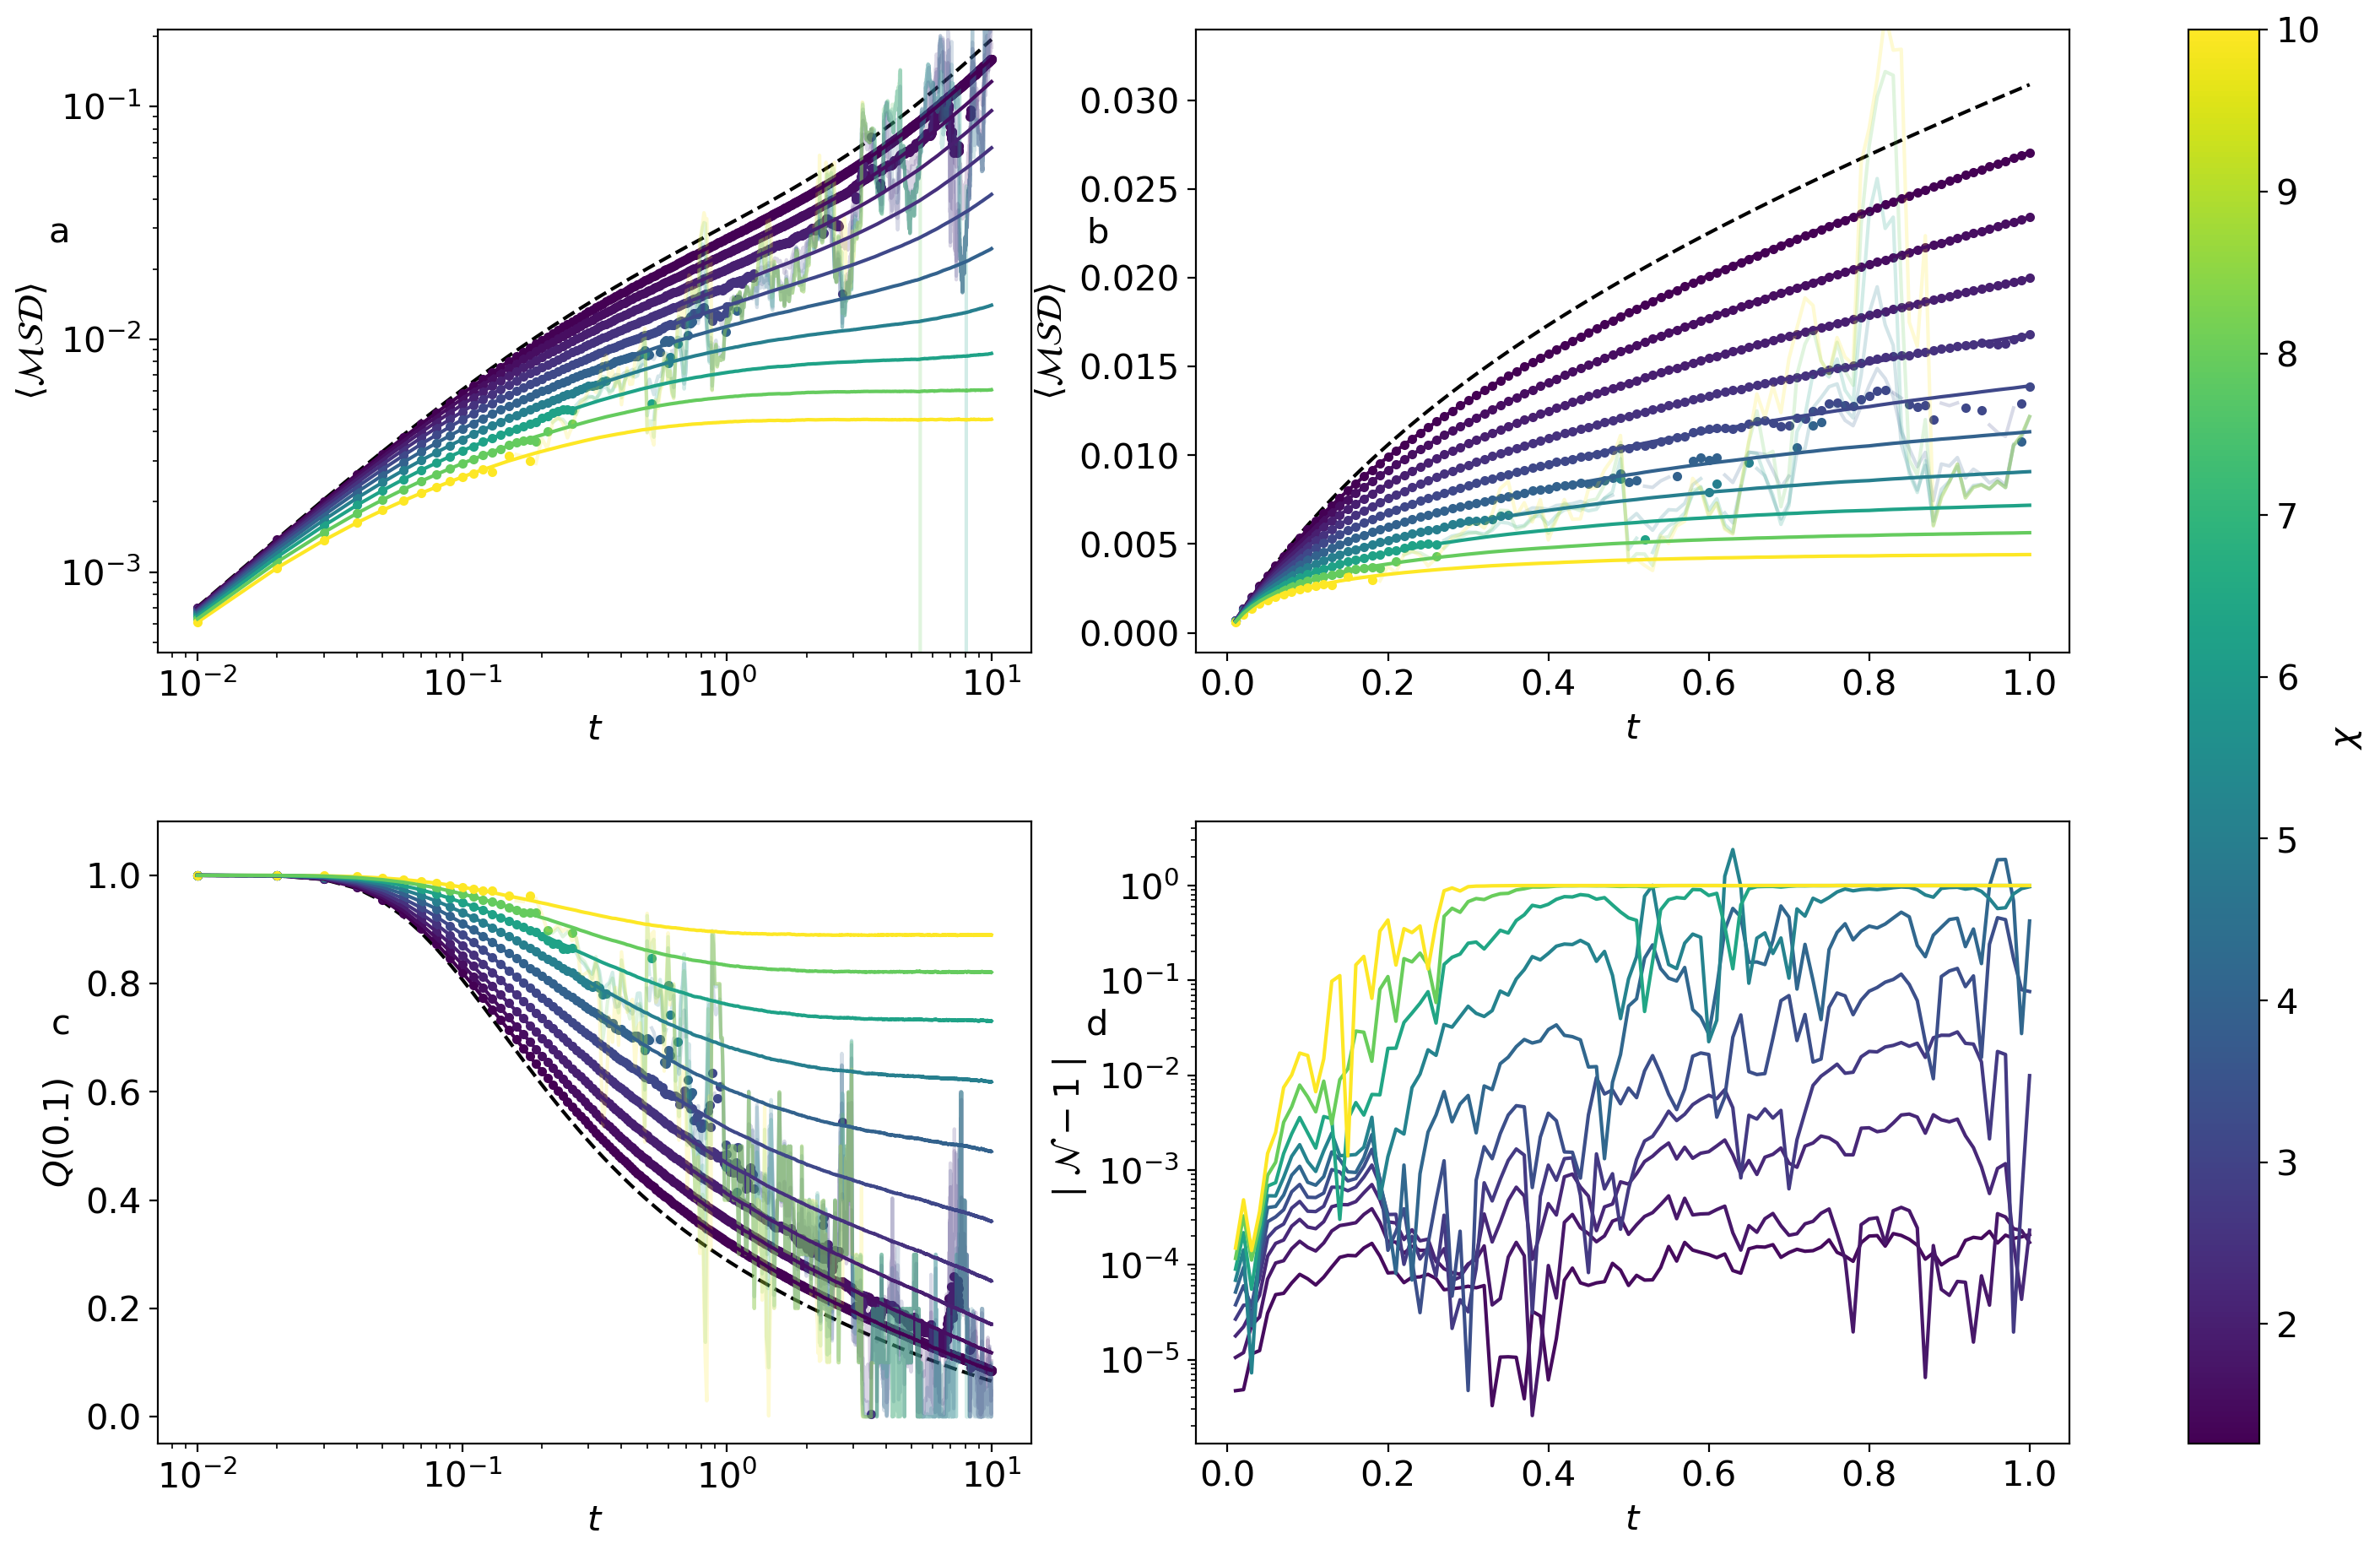

In [75]:
paper_figure(data, data_val, max_t=10.0, mask_opacity=0.2)

In [138]:
print(data["dVs"])

[ 0.         -0.25892541 -0.58489319 -0.99526231 -1.51188643 -2.16227766
 -2.98107171 -4.01187234 -5.30957344 -6.94328235 -9.        ]


In [63]:
data_lj = collect_h5_files_into_data(lj_pred_25)

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


In [64]:
data_lj_val = collect_h5_files_into_data(lj_val_25, val=True, v0=0.1)

0 of 110
11 of 110
22 of 110
33 of 110
44 of 110
55 of 110
66 of 110
77 of 110
88 of 110
99 of 110


In [52]:
data_lj_val["dVs"]

array([ 0.        , -0.25892541, -0.58489319, -0.99526231, -1.51188643,
       -2.16227766, -2.98107171, -4.01187234, -5.30957344, -6.94328235,
       -9.        ])

In [70]:
data_lj["real"]

10000000

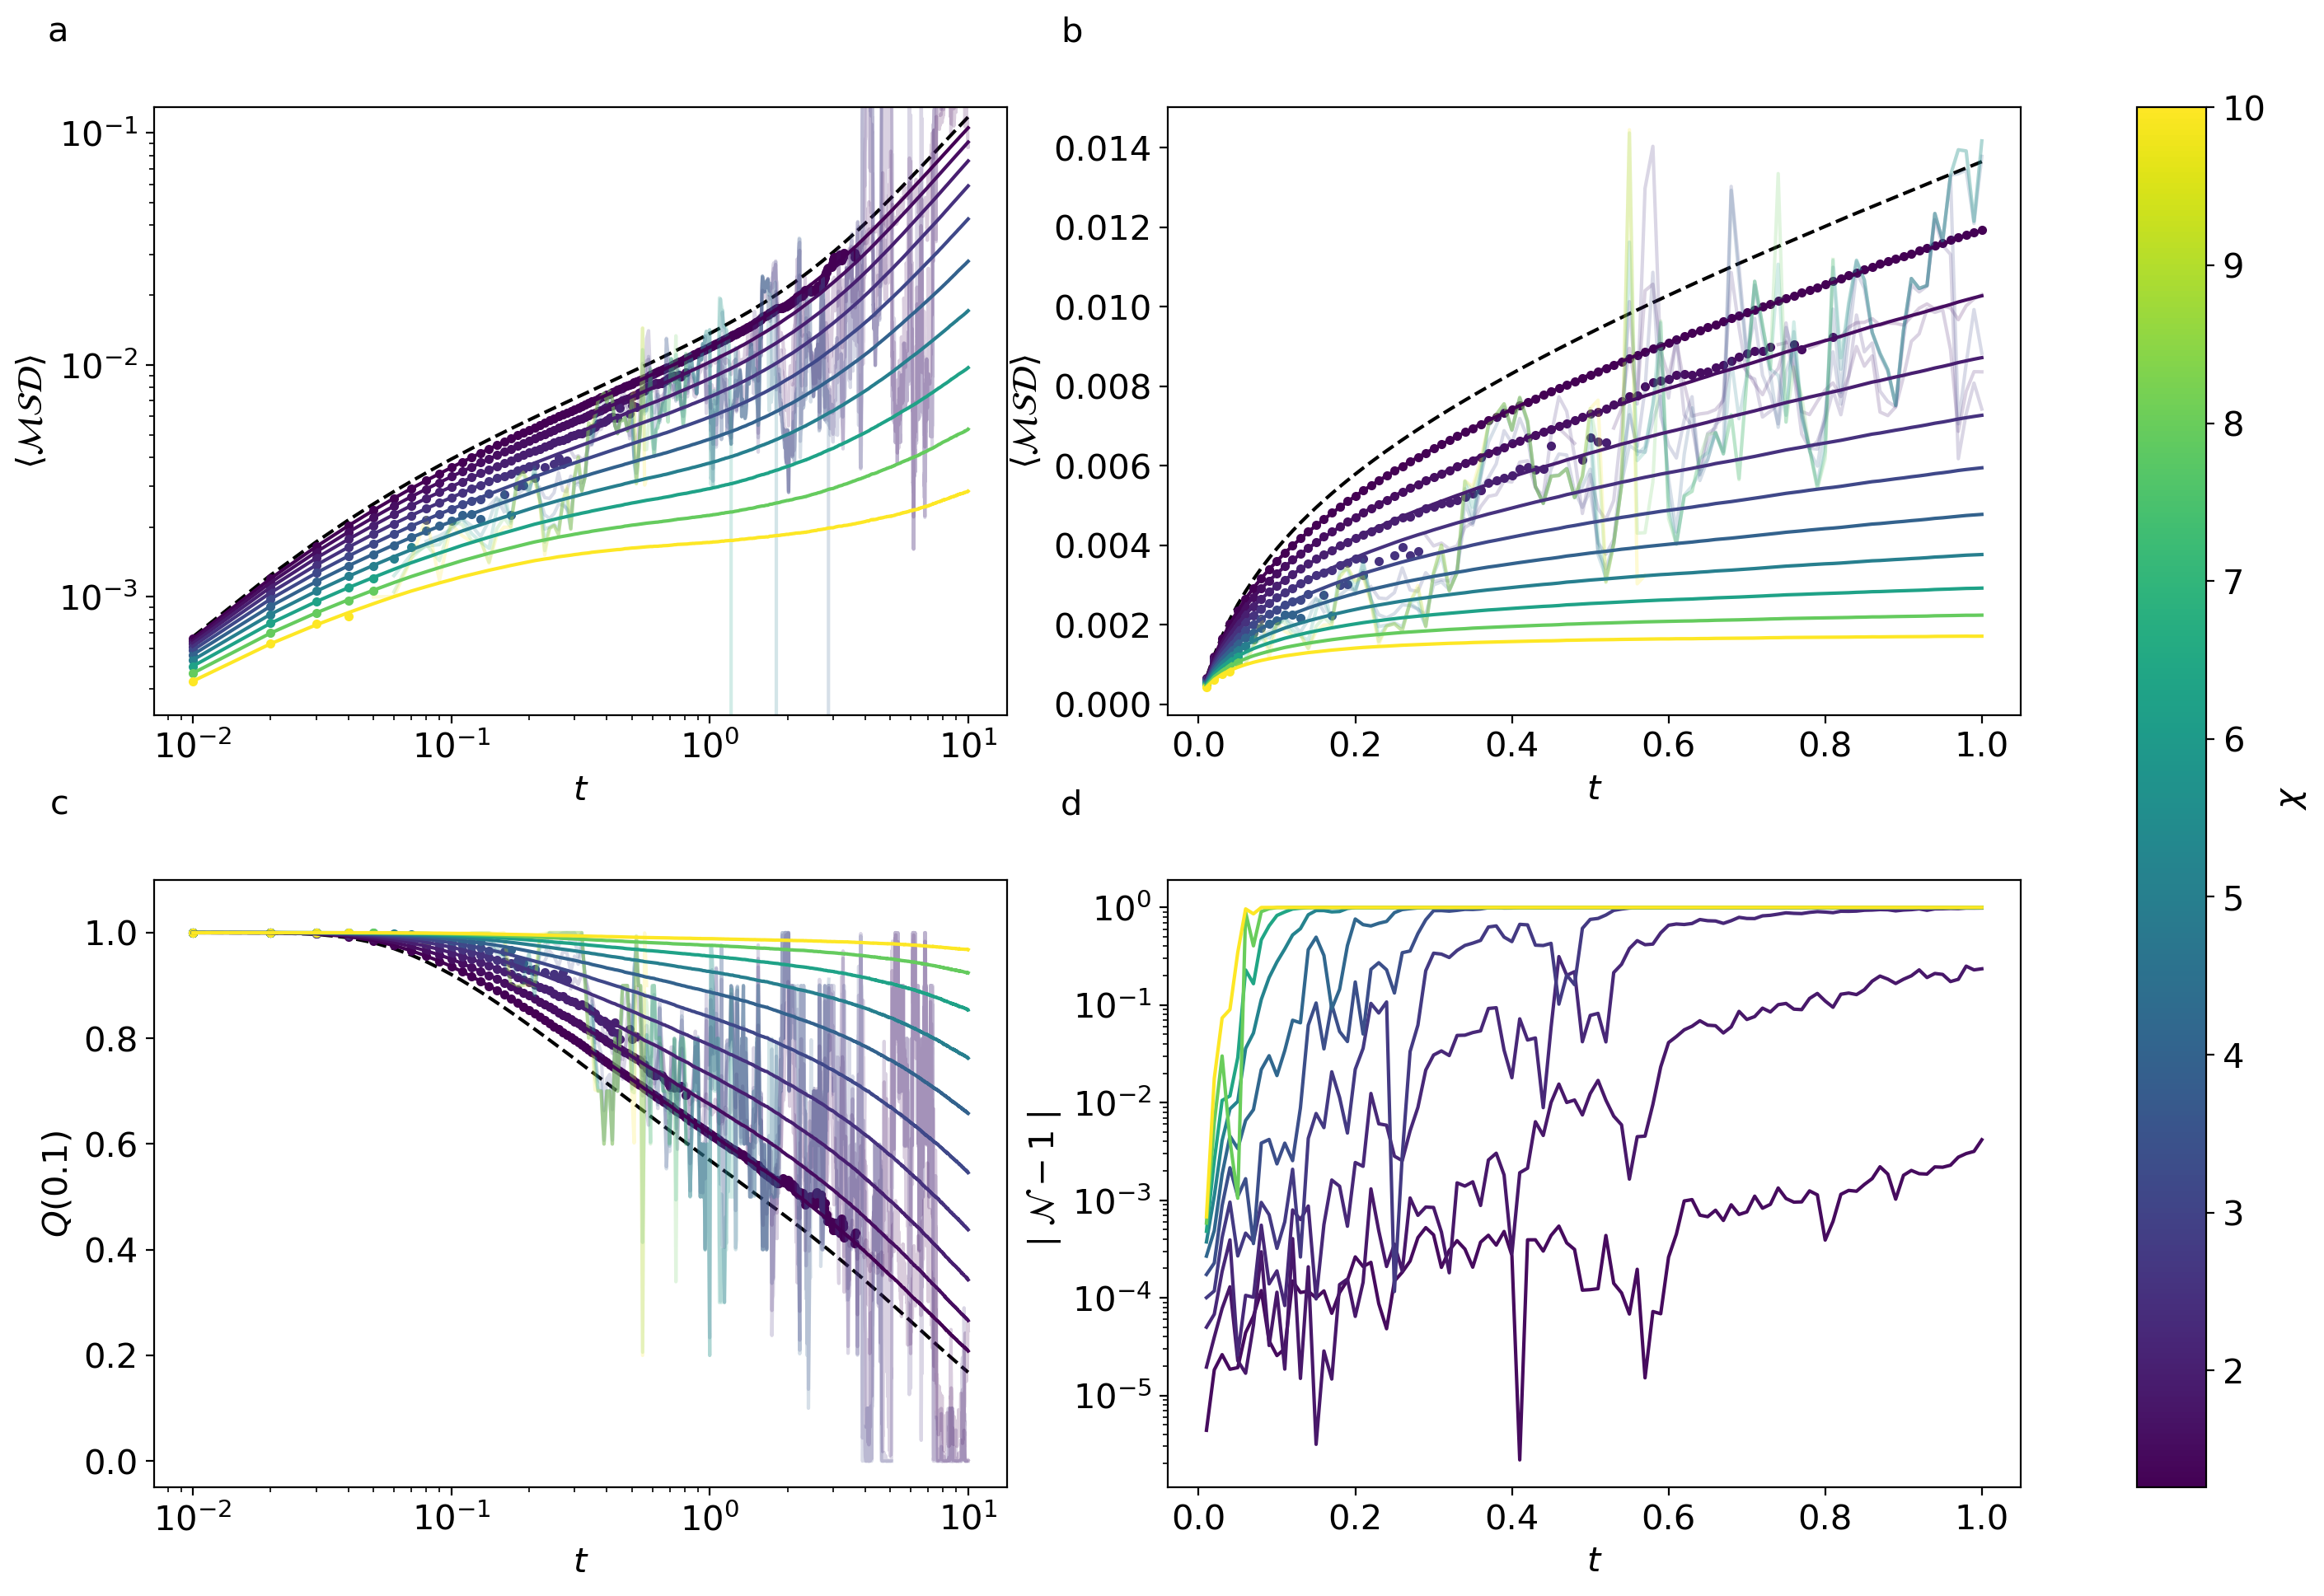

In [69]:
paper_figure(data_lj, data_lj_val, max_t=10.0, mask_opacity=0.2)
plt.savefig("final_lj.pdf")

In [140]:
def make_uncert_quant_data(files):
    
    data = {}
    
    for i, f in enumerate(sorted(files)):
        if i%(len(files)//10)==0:
            print(i, "of", len(files))
        with h5py.File(f, "r") as f:
            if i == 0:
                data["time"] = f["data"]["time"][:]
                data["Norm"] = f["data"]["Norm"][:]
                data["Norm2"] = f["data"]["Norm2"][:]
#                 data["MSD"] = f["data"]["MSD"][:]
                data["POS"] = f["data"]["POS"][:]
#                 data["Q"] = f["data"]["Q"][:]
                data["real"] = f["real"][0]
                
                time = f["data"]["time"][:]
                dVs = f["param"]["dVs"][:]
                init_x = f["meta"]["init_x"][:]
                dim = f["meta"]["dim"][()]
                num_parts = len(init_x)
                visc = f["meta"]["visc"][()]
                l = f["meta"]["len"][()]
                beta = f["meta"]["beta"][()]
                
                
            else:
                data["Norm"] += f["data"]["Norm"][:]
                data["Norm2"] += f["data"]["Norm2"][:]
#                 data["MSD"] += f["data"]["MSD"][:]
                data["POS"] += f["data"]["POS"][:]
#                 data["Q"] += f["data"]["Q"][:]
                data["real"] += f["real"][0]
    
    norm = data["Norm"]
    N = data["real"]
    pos_bias = data["POS"]
    pos_shape = pos_bias.shape
    for i in range(pos_shape[0]):
        for j in range(pos_shape[1]):
            pos_bias[i, j] /= norm[i, j]
    Ib_mean = norm/N
    Ib_var = data["Norm2"]/N - Ib_mean*Ib_mean
    
    out_dict = {"time": time, "dVs": dVs, "Ib_mean": Ib_mean, "Ib_var": Ib_var, "pos_bias": pos_bias,
                "beta": beta, "N": N, "num_parts": num_parts, "dim": dim, "init_pos": init_x,
                "visc": visc, "L": l}
    
    return out_dict

In [161]:
data_hertz_highdt = collect_h5_files_into_data(hertz_pred_highdt)

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


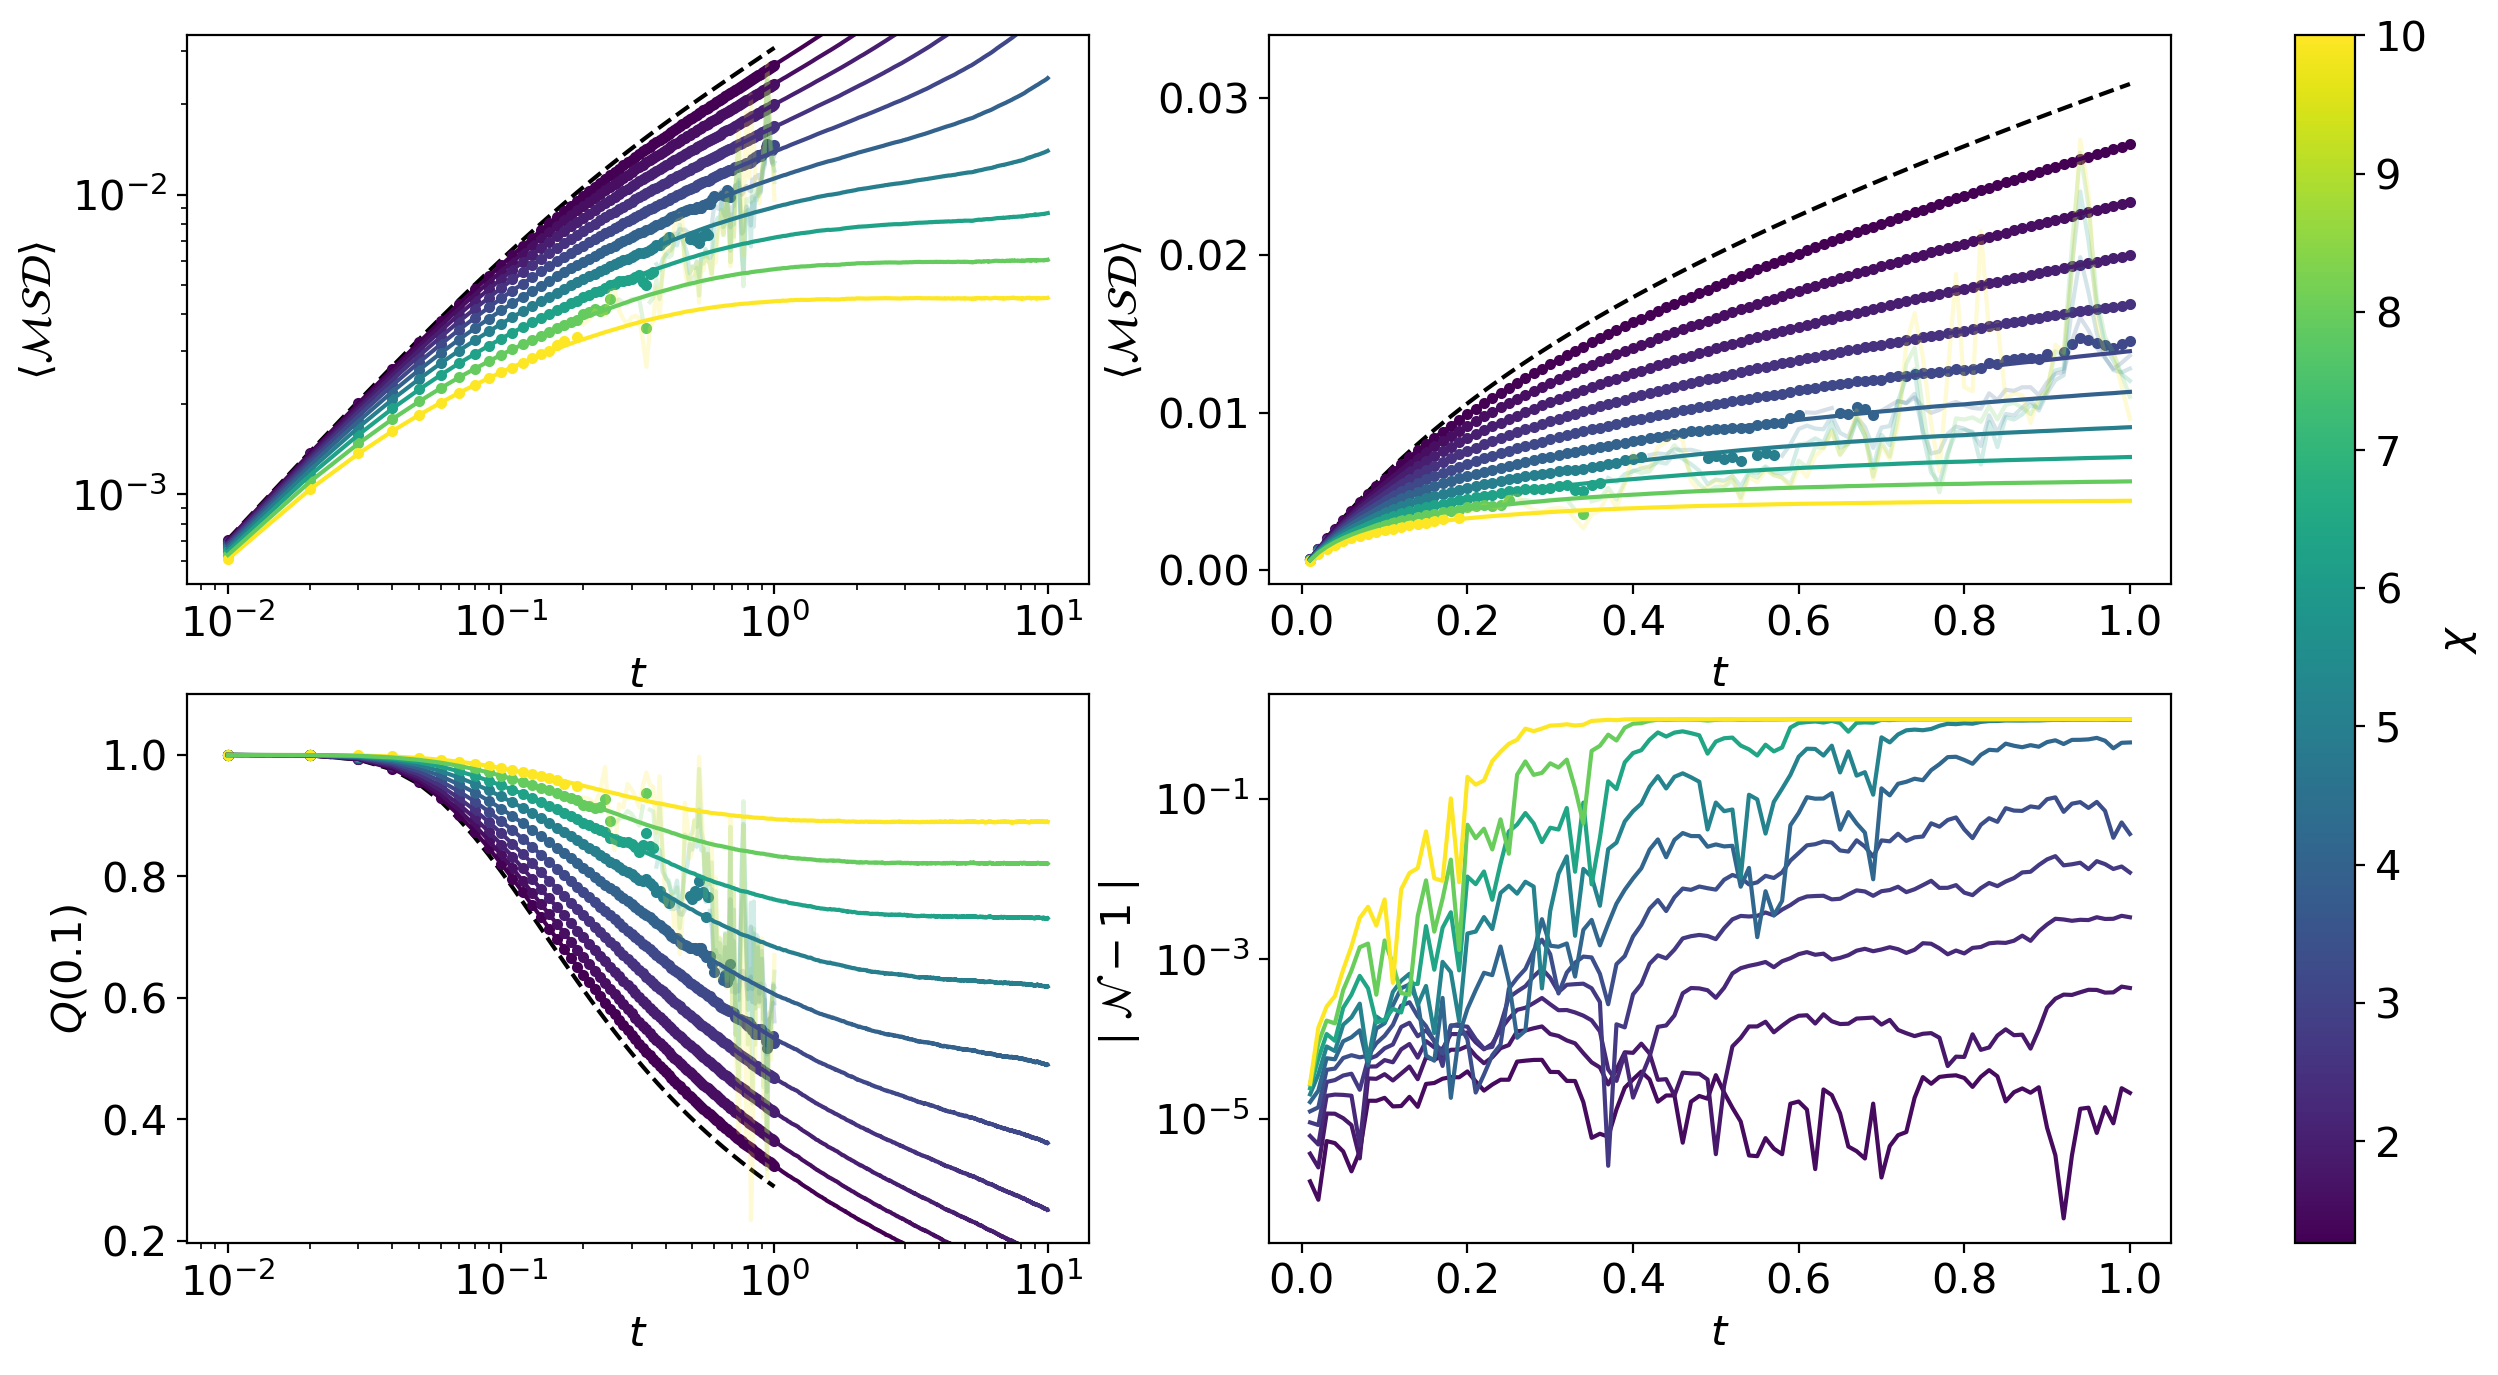

In [162]:
paper_figure(data_hertz_highdt, data_val, max_t=10.0, mask_opacity=0.2)

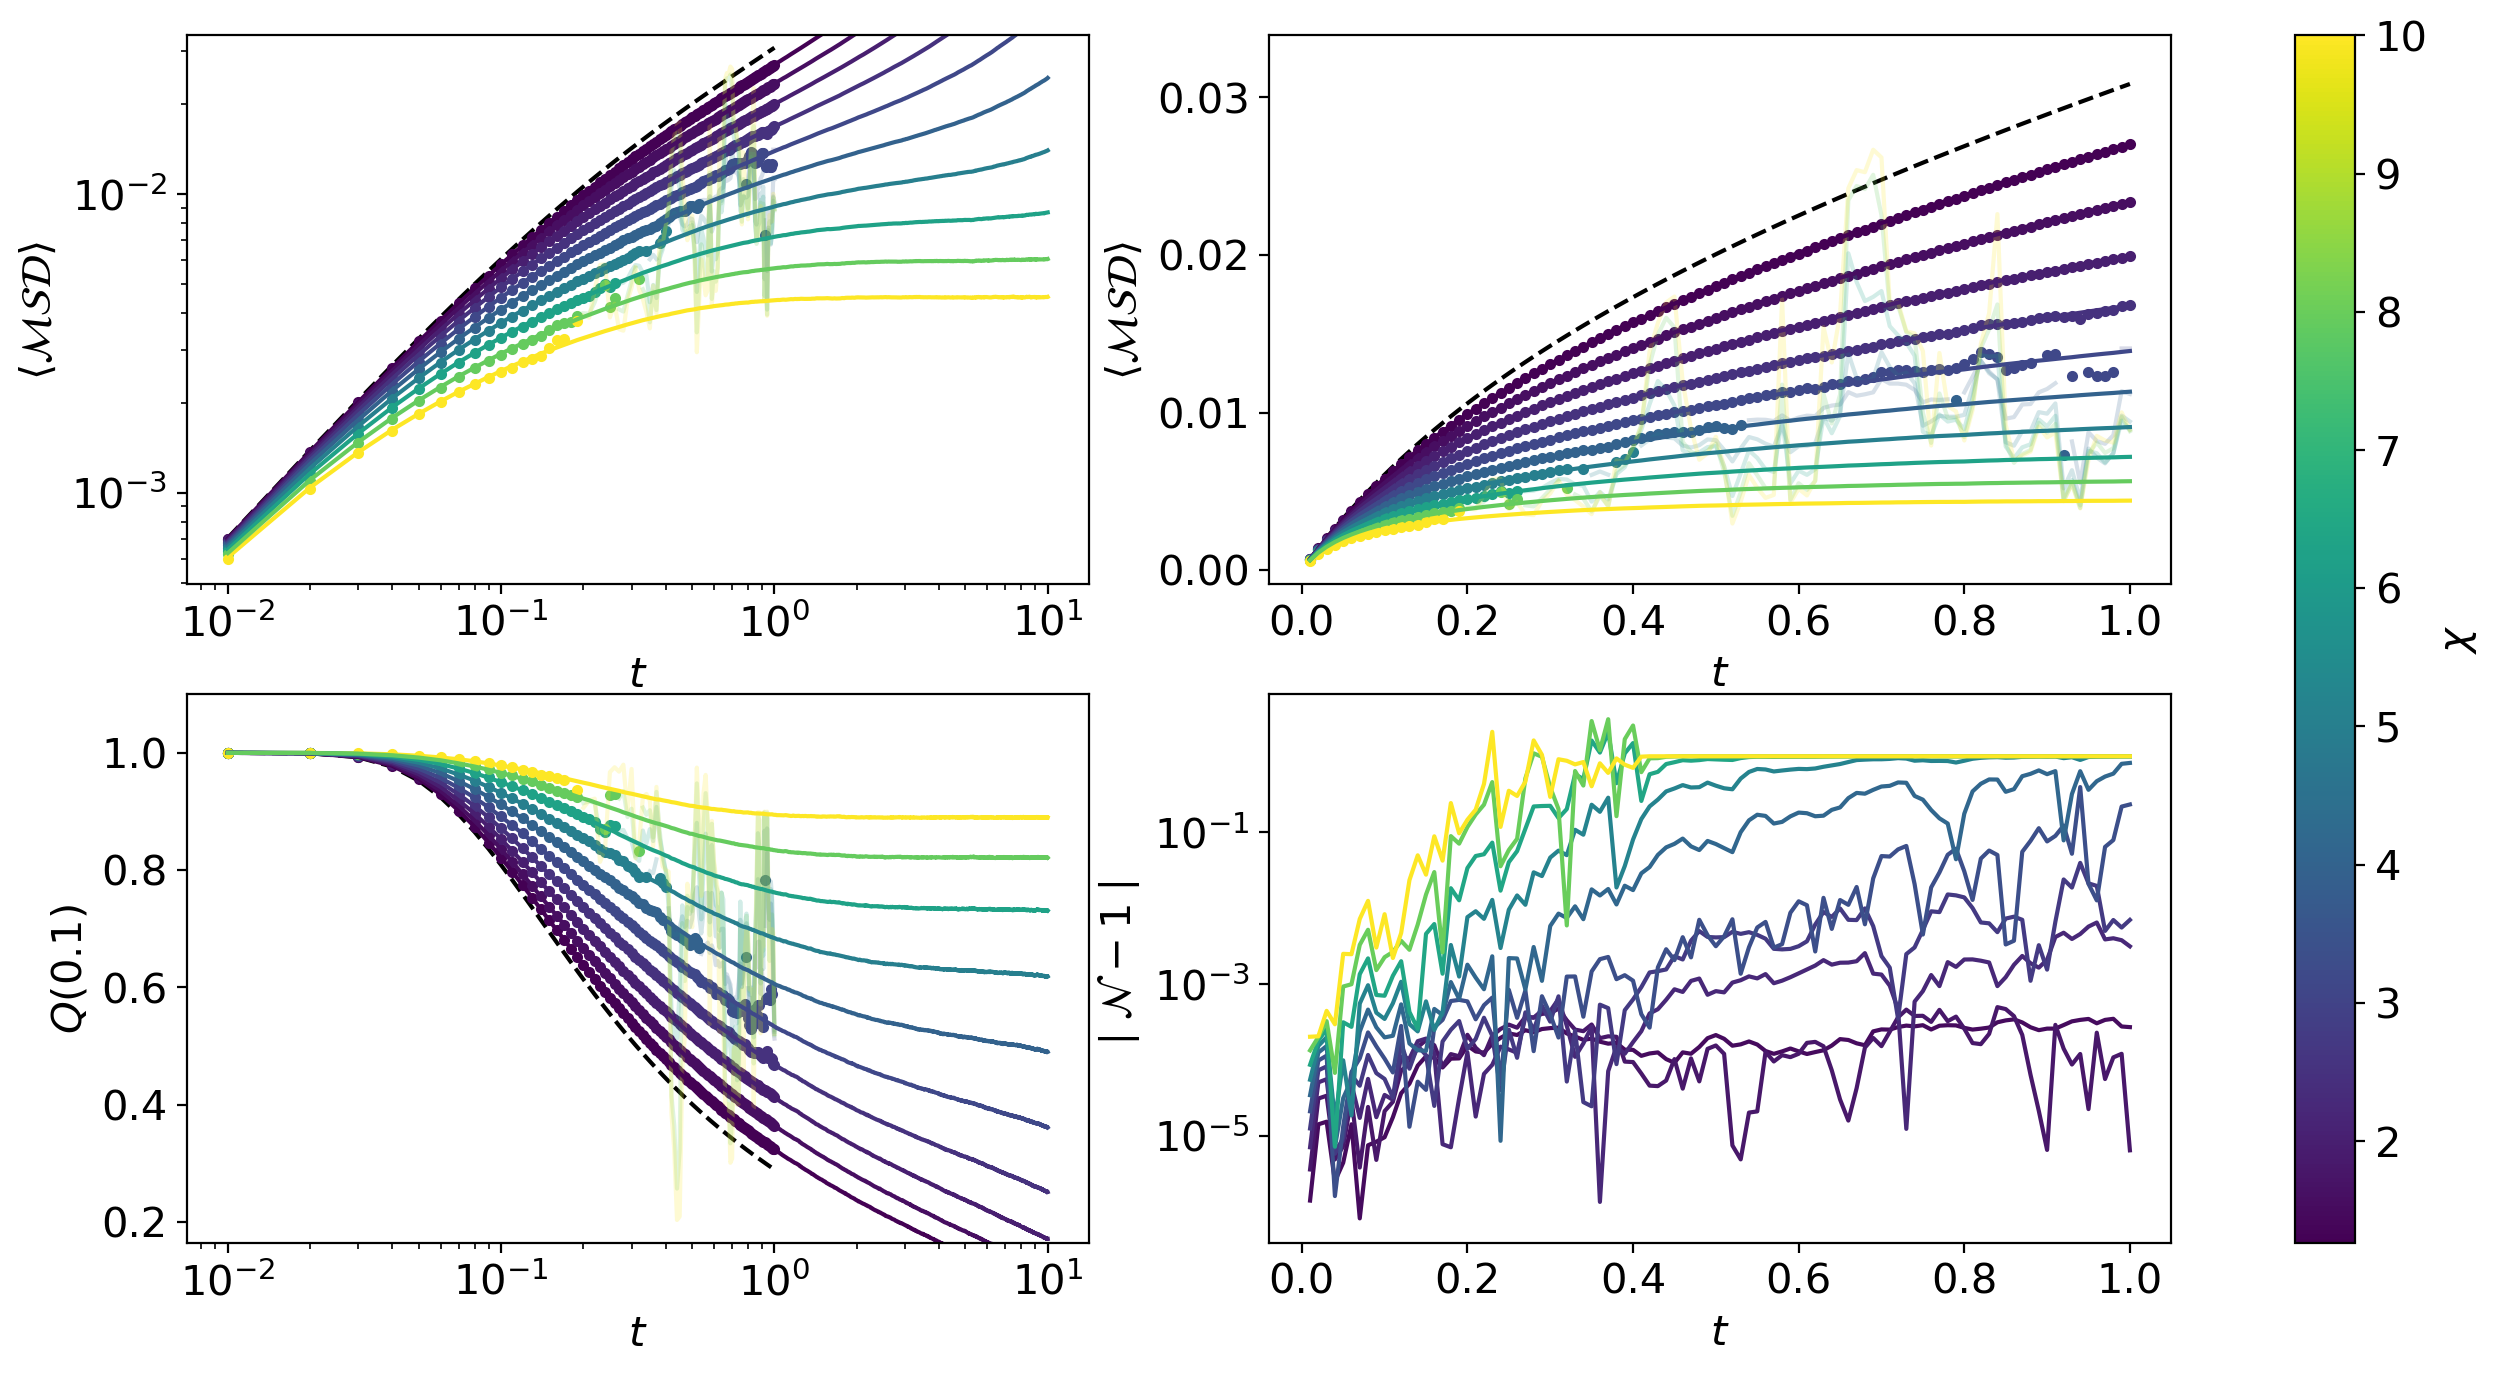

In [154]:
paper_figure(data_hertz_highdt, data_val, max_t=10.0, mask_opacity=0.2)

In [166]:
data_lj_highdt = collect_h5_files_into_data(lj_pred_highdt)

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


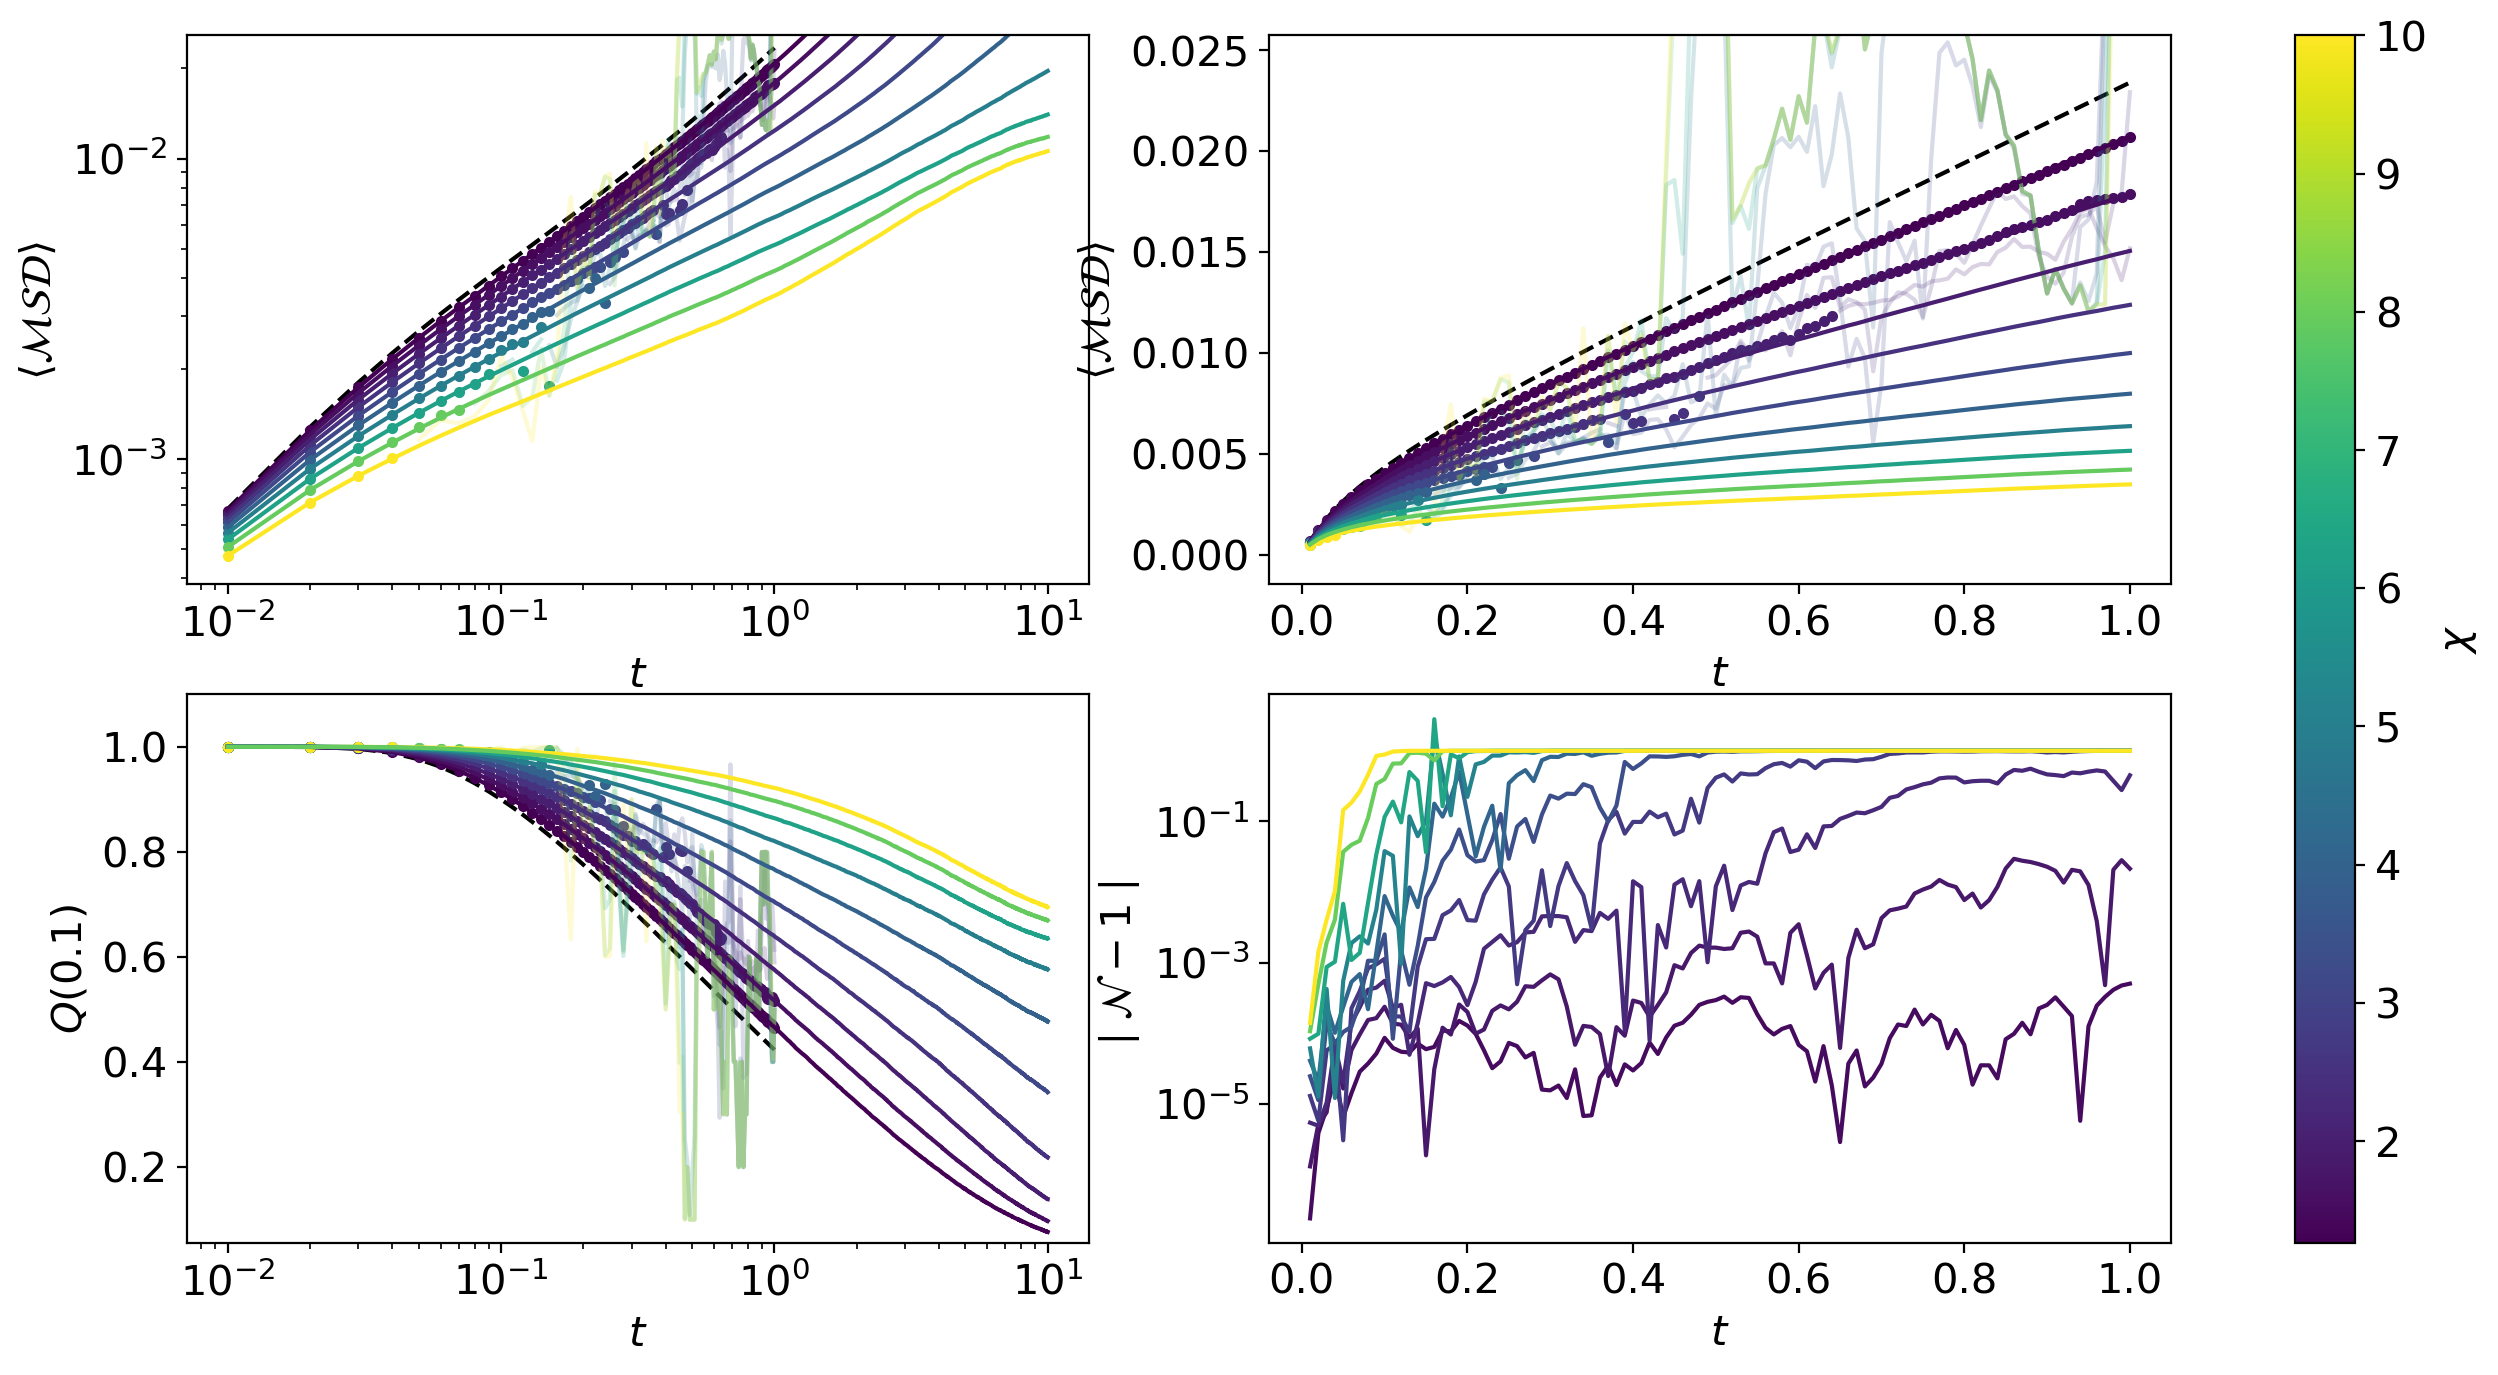

In [160]:
paper_figure(data_lj_highdt, data_lj_val, max_t=10.0, mask_opacity=0.2)

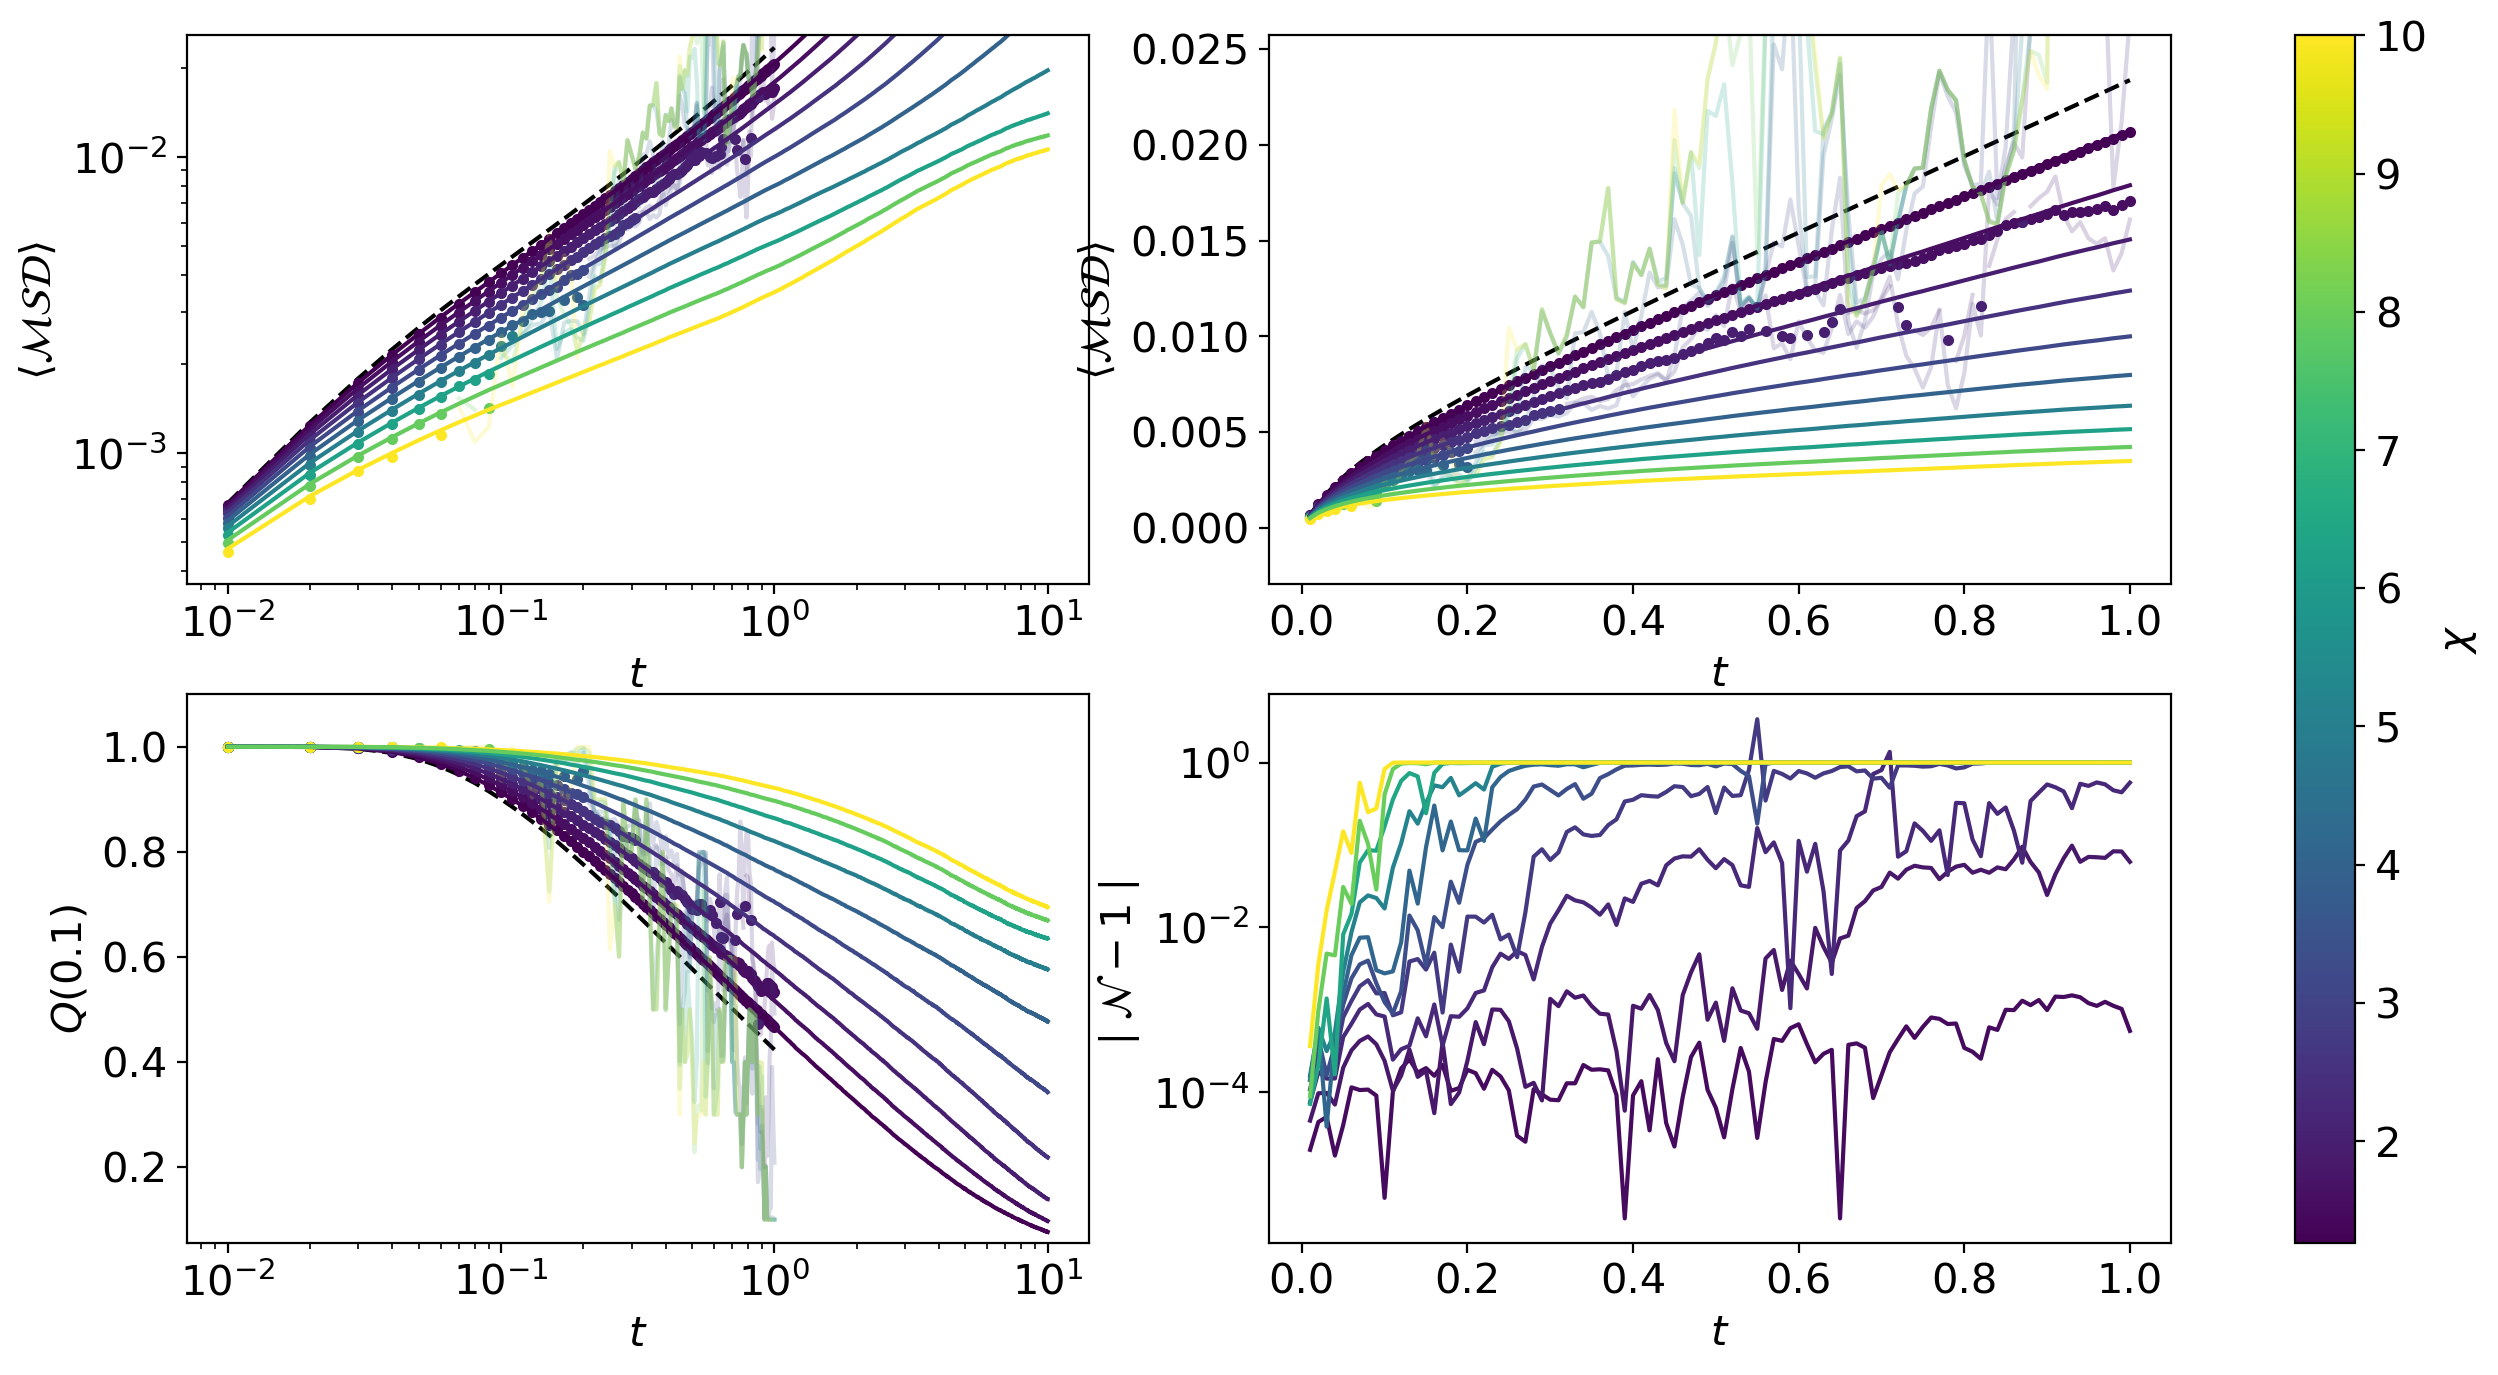

In [167]:
paper_figure(data_lj_highdt, data_lj_val, max_t=10.0, mask_opacity=0.2)

In [141]:
uncert_data_hertz = make_uncert_quant_data(hertz_pred)

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


<ipython-input-140-357c684afda3>:42: RuntimeWarning: invalid value encountered in true_divide
  pos_bias[i, j] /= norm[i, j]


In [155]:
savemat(f"{main_dir}/uncert_quant/hertz.mat", uncert_data_hertz)

In [33]:
uncert_data_lj = make_uncert_quant_data(lj_pred_25)

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


<ipython-input-29-357c684afda3>:42: RuntimeWarning: invalid value encountered in true_divide
  pos_bias[i, j] /= norm[i, j]


In [34]:
lj_pred_25[0]

'/home/igraham/data/MD_LV_paper_data/lj_pred_lastone/genvariant_n-10_na-4_l-3.015113445777636_t-0.1_time-10_dt-1e-3_visc-5_seed-13000_phi-1.1000_pot-lj_rs-1_vs-0.1.h5'

In [36]:
uncert_data_lj["L"] = 3.015113445777636

In [157]:
savemat(f"{main_dir}/uncert_quant/lj.mat", uncert_data_lj)